In [1]:
import numpy as np

def train_test_split(X: np.ndarray, Y: np.ndarray, test_size:float=0.3, shuffle:bool=True):
    indices = np.arange(X.shape[0])

    if shuffle:
        np.random.shuffle(indices)

    train_end_ind = int(X.shape[0] * (1-test_size)+1)

    return X[:train_end_ind], Y[:train_end_ind], X[train_end_ind:], Y[train_end_ind:]




class BatchGenerator:  # TESTED
    def __init__(self, X: np.ndarray, Y: np.ndarray, batch_size: int, shuffle: bool = True):
        """
        X: np.ndarray
            Входные данные, размеры [n_samples, n_features]
        Y: np.ndarray
            Метки данных, размеры [n_samples] или [n_samples, n_classes]
        batch_size: int
            Размер мини-батча
        shuffle: bool
            Перемешивать ли данные перед каждой эпохой
        """
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = X.shape[0]  # Количество примеров
        self.indices = np.arange(self.num_samples)  # Индексы для перемешивания

    def __iter__(self):
        """
        Итератор для перебора батчей.
        """
        if self.shuffle:
            # print("Перемешано")
            # Перемешиваем индексы в начале каждой эпохи
            np.random.shuffle(self.indices)
        
        
        # print(self.indices)
        # Возвращаем батчи данных
        for start_idx in range(0, self.num_samples - self.batch_size + 1, self.batch_size):
            end_idx = start_idx + self.batch_size  
            batch_indices = self.indices[start_idx:end_idx]
            # print(batch_indices)
            yield self.X[batch_indices], self.Y[batch_indices]

    def __len__(self):
        """
        Возвращает количество батчей за одну эпоху.
        """
        return (self.num_samples // self.batch_size)



class ModelLayer:
    def __init__(self):
        self.previous_layer = None
        self.next_layer = None
        self.output = None
        self.input = None
        self.backprop_gradient = None
        self.grad_kostil = 1
        self.training = True
        self.lr = None
        self.weights_grad = None
        self.bias_grad = None 
        self.Weights = None
        self.bias = None

    def __call__(self, X: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)
        pass
    
    def backprop(self, grad: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)
        pass

    def init_weights(self):
        pass

    def apply_gradient(self):
        pass        


class Softmax(ModelLayer): # TESTED
    """Класс реализующий софтмакс
        Примеры использования:

        num_class = 3
        X = (np.random.random_sample((10, num_class)) * 10)
        print(X)
        Y = np.argmax(X, axis=1)
        print(Y)

        softmax = Softmax()
        my_softmax = softmax(X)
    """
    def __init__(self):
        super().__init__()

    def __call__(self, X: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)
        #Решаем проблему огромных экспонент
        # print(f"{X=}")
        exp_pred = np.exp(X - np.max(X, axis=1, keepdims=True))
        # exp_pred = np.where(exp_pred==0, 1e-10, exp_pred)
        # print("EXPPRED:", exp_pred)
        # print('norm exp', np.exp(X))
        self.output = exp_pred / np.sum(exp_pred, axis=1, keepdims=True) 
        # print(f"{self.output=}")
        return self.output
    
    def __repr__(self) -> str:
        return f"Текущая self.y_proba {self.output}"
    
    def add_regulaizer(self, regulaizer:int):
        self.grad_kostil = 1/regulaizer
        print(self.grad_kostil)
    
    # def backprop(self, Y_real: np.ndarray):
    #     Y_real = one_hot(Y_real)
    #     self.backprop_gradient = (self.output - Y_real) * self.grad_kostil
    #     return self.backprop_gradient

    def backprop(self, grad: np.ndarray, debug:bool = False):
        if debug:
            print(self.__class__.__name__)

        self.backprop_gradient = grad
        return self.backprop_gradient


class CrossEntropyLoss: # TESTED
    """Класс реализующий кроссэнтропию
        Y_real ПОДАЁТСЯ В ВИДЕ ОДНОМЕРНОГО ВЕКТОРА!!!!!!
        Пример использования:
        
        softmax = Softmax()
        my_loss = CrossEntropyLoss(softmax=softmax, reduction="sum")
        my_loss(logit_pred=X, Y_real=Y)
        
    """
    def __init__(self, reduction = "mean"):
        self.reduction = reduction
        self.batch_size = 0
        self.backprop_gradient = None

    def __call__(self, softmax_pred: np.ndarray, Y_real: np.ndarray): # TESTED
        # one hot encoding

        self.batch_size = Y_real.shape[0]
        Y_real = one_hot(Y_real, softmax_pred.shape[1])
        # print(f"{softmax_pred=}")
        # print(f"{softmax_pred.shape}")
        # print(f"{Y_real=}")
        # raise Exception("STOP")
        if self.reduction == "sum":
            self.backprop_gradient = (softmax_pred - Y_real)
            return -np.sum(Y_real * np.log(softmax_pred))
        elif self.reduction == "mean":
            #Надо вывести в оптимизатор
            self.backprop_gradient = (softmax_pred - Y_real) / softmax_pred.shape[0]
            return -np.sum(Y_real * np.log(softmax_pred))/softmax_pred.shape[0]
        else:
            raise NotImplementedError("Метод не реализован")
    
    
    def get_backprop_gradient(self):
        return self.backprop_gradient
    



class Linear(ModelLayer):
    """
        Класс создающий линейный полносвязный слой

    """
    def __init__(self, input_neuron:int, output_neuron:int):
        super().__init__()
        self.input_neuron = input_neuron
        self.output_neuron = output_neuron
        self.lr = None
        self.init_weights()
        
    
    def __call__(self, X: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)
            print(f"{X=}")
            print(f"{self.Weights=}")
            
        self.input = X.copy()
        self.output = X @ self.Weights.T + self.bias 
        return self.output
    

    def backprop(self, grad: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)

        self.backprop_gradient = grad @ self.Weights
        self.weights_grad = grad.T @ self.input
        self.bias_grad = np.sum(grad, axis=0)
        return self.backprop_gradient
        

    def init_weights(self):
        
        weights_shape = (self.output_neuron, self.input_neuron)

        self.bias = np.random.random_sample(self.output_neuron)+0.001
        self.Weights = np.random.random_sample(weights_shape)-0.5
        self.weights_grad = np.zeros(weights_shape)
        self.bias_grad = np.zeros(self.output_neuron)

    def apply_gradient(self):
        self.Weights -= self.weights_grad
        self.bias -= self.bias_grad




class LeackyRelu(ModelLayer):
    """
        Класс создающий слой активации LeakyRelu

    """
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def __call__(self, X: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)

        self.input = X.copy()
        self.output = np.where(X >= 0, X, self.alpha * X)
        return self.output
    
    def backprop(self, grad: np.ndarray, debug:bool = False):
        if debug:
            print(self.__class__.__name__)
        self.backprop_gradient = np.where(self.input >=0, 1, self.alpha)
        self.backprop_gradient = self.backprop_gradient * grad
        return self.backprop_gradient



class NeuroModel:
    def __init__(self, *layers:ModelLayer, lr:np.float64 = 0.003):
        self.layers = layers

        self.layers[0].lr = lr
        for i in range(1, len(self.layers)):
            self.layers[i].lr = lr
            #Связывание слоёв для градиента
            self.layers[i].previous_layer = self.layers[i - 1]
            self.layers[i - 1].next_layer = self.layers[i]
            


    def __call__(self, X: np.ndarray, debug:bool=False):

        output = X
        for layer in self.layers:
            output = layer(output, debug=debug)
        return output
    

    def backward(self, loss_grad:np.ndarray, debug:bool=False):
        
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backprop(grad, debug=debug)

    def __repr__(self):
        """Удобное представление для отображения слоев"""
        return " -> ".join([layer.__class__.__name__ for layer in self.layers])




class AdamOptimizer:
    def __init__(self, model:NeuroModel, beta1:float=0.9, beta2:float=0.99, debug=False): #learning_rate:float,
        self.V_w = [np.zeros(layer.weights_grad.shape) if layer.weights_grad is not None else None  for layer in model.layers]
        self.A_w = [np.zeros(layer.weights_grad.shape) if layer.weights_grad is not None else None  for layer in model.layers]
        self.V_b = [np.zeros(layer.bias_grad.shape) if layer.bias_grad is not None else None for layer in model.layers]
        self.A_b = [np.zeros(layer.bias_grad.shape) if layer.bias_grad is not None else None for layer in model.layers]
        self.layer_amm = len(model.layers)
        self.beta1 = beta1
        self.beta2 = beta2
        self.model = model
        # self.learning_rate = learning_rate
        self.iteration = 1
        self.debug = debug

    def step(self):
        for layer_i in range(self.layer_amm):
            if self.debug:
                print(self.V_w)

            if self.V_w[layer_i] is None:
                continue
            
            # Коррекция для весов
            self.V_w[layer_i] = self.beta1 * self.V_w[layer_i] + (1 - self.beta1) * self.model.layers[layer_i].weights_grad
            self.A_w[layer_i] = self.beta2 * self.A_w[layer_i] + (1 - self.beta2) * self.model.layers[layer_i].weights_grad ** 2

            #Корректировка смещений
            self.V_b[layer_i] = self.beta1 * self.V_b[layer_i] + (1 - self.beta1) * self.model.layers[layer_i].bias_grad
            self.A_b[layer_i] = self.beta2 * self.A_b[layer_i] + (1 - self.beta2) * self.model.layers[layer_i].bias_grad ** 2

            self.model.layers[layer_i].weights_grad = self.model.layers[layer_i].lr * ((self.V_w[layer_i] / (1 - self.beta1 ** self.iteration)) 
                                                                             / (np.sqrt(self.A_w[layer_i] / (1 - self.beta2 ** self.iteration)) + 0.0001))
            self.model.layers[layer_i].bias_grad =  self.model.layers[layer_i].lr * ((self.V_b[layer_i]/(1-self.beta1 ** self.iteration)) 
                                                                           / (np.sqrt(self.A_b[layer_i] / (1 - self.beta2 ** self.iteration)) + 0.0001))

            self.model.layers[layer_i].apply_gradient()

        self.iteration += 1


In [2]:

def my_im2col(X: np.ndarray, H_out:int, W_out:int, kernel_size:tuple, stride:tuple, dilation:tuple, in_chan:int=0, _reshape:bool=True) ->np.ndarray:
    """Im2col implementation using numpy memory access

    :param X: Входной массив данных в формате shape[Количество батчей, количество каналов, высота, ширина]
    :type X: np.ndarray
    :param H_out: Высота выходного массива после операции свёртки. 
              H_out = 1 + (H_in + 2*padding[0] - dilation[0]  * (kernel_size[0] - 1) - 1) // stride[0]
    :type H_out: int
    :param W_out: Ширина выходного массива после операции свёртки.
              W_out = 1 + (W_in + 2*padding[1] - dilation[1]  * (kernel_size[1] - 1) - 1) // stride[1]
    :type W_out: int
    :param kernel_size: Размер ядра свёртки
    :type kernel_size: tuple
    :param stride: Смещение по вертикали и горизонтали на 1 шаг. 
              Первый элемент - смещение по-вертикали, второй элемент - смещение по-горизонтали
    :type stride: tuple
    :param dilation: Расстояние между элементами ядра.
              Первый элемент - расстояние по-вертикали, второй элемент - расстояние по-горизонтали
    :type dilation: tuple
    :return: Возвращает тензор являющийся im2col для входной матрицы X по ядру размером kernel_size
    :rtype: np.ndarray
    

    
        
    Пример использования приведён ниже:

    X = np.arange(48).reshape(6, -1)
    W = np.arange(6).reshape(2, 3)

    print(X)
    print(W)

    H_in, W_in = X.shape
    kernel_size = W.shape
    padding = (0, 0)
    dilation = (1, 1)

    stride = (2, 1)

    H_out = 1 + (H_in + 2*padding[0] - dilation[0]  * (kernel_size[0] - 1) - 1) // stride[0]
    W_out = 1 + (W_in + 2*padding[1] - dilation[1]  * (kernel_size[1] - 1) - 1) // stride[1]

    
    my_im2col(X=X, H_out=H_out, W_out=W_out, kernel_size=kernel_size, stride=stride, dilation=dilation)

    в np.lib.stride_tricks.as_strided 
    
    За shape отвечают следующие величины:          shape=(num_batch, in_chan, H_out, W_out, *kernel_size)
    Первое - Размер выходного батча
    Второе - Количество выходных каналов
    Третье - размер выходного тензора по высоте
    Четвёртое - размер выходного тензора по длине
    Пятое и Шестое - размер выходного тензора по высоте и длине ядра. 
        То есть то, какого размера должны быть индивидуальные матрицы которые будут переменожаться на ядра 
    
    
    За strides отвечают следующие элементы: для прохода по двумерной матрице двумеерной матрицей надо:

    batch_stride, c_stride, h_stride, w_stride = X.strides
    strides=(batch_stride, c_stride, h_stride*stride[0], w_stride*stride[1], h_stride*dilation[0], w_stride*dilation[1])

    Первый элемент - Смещение по батчам

    batch_stride

    Второй элемент - Смещение по каналам

    Третий элемент - Смещение по вертикали. 
        Так как мы играем с адресацией в памяти, то это ширина входной матрицы умноженная на количество строчек по которым происходит смещение,
        В общем случае это  h_stride*stride[0]
    
        W_in*stride[0]  
    
    Четвёртый элемент - Смещение по горизонтали, w_stride*stride[1]

    Пятый элемент - Крепкий орешек (нет). Разница между первым и последующим элементом, который будет передаваться в ядро по вертикали. 
        То есть по сути расстояние между элементами которые будут пихаться в ядро по вертикали.
        Так как мы играем с адресацией в памяти, то это ширина входной матрица  умноженная на количество элементов по вертикали, которые мы хотим пропустить - 1. 
        Если этот параметр равен единицы, то строки берутся последовательно.
        Иначе - пропускается n-1 строка.
        В общем случае это h_stride*dilation[0]
        W_in*dilation[0]
    
    Шестой элемент - то же что и третий, но по горизонтали. (Вспоминай гифку с матрицей как ситом)   w_stride*dilation[1]

    Так как операции происходят с памятью надо умножить на 4. В теории, зависит от dtype, но тесты не подтвердили.

    """


    if X.ndim == 4:
        num_batch = X.shape[0]
        if not in_chan:
            in_chan = X.shape[1]
        batch_stride, c_stride, h_stride, w_stride = X.strides
        # print(f"{num_batch=}, {batch_stride, c_stride, h_stride, w_stride}, {in_chan=}, {H_out=}, {W_out=}")
        shapes = (num_batch, in_chan, H_out, W_out, *kernel_size)
        strides = (batch_stride, c_stride, h_stride*stride[0], w_stride*stride[1], h_stride*dilation[0], w_stride*dilation[1])
        
                                                                                                        # (W_in*stride[0], stride[1], W_in*dilation[0], dilation[1])                 
    elif X.ndim == 3:
        if not in_chan:
            in_chan = X.shape[0]
        
        c_stride, h_stride, w_stride = X.strides
        # print(f"X.ndim == 3\n{c_stride, h_stride, w_stride}, {H_out=}, {W_out=}, {in_chan=}")
        shapes = (in_chan, H_out, W_out, *kernel_size)
        strides = (c_stride, h_stride*stride[0], w_stride*stride[1], h_stride*dilation[0], w_stride*dilation[1])


    elif X.ndim == 2:
        h_stride, w_stride = X.strides
        # print(f"{h_stride, w_stride}, {H_out=}, {W_out=}")
        shapes = (H_out, W_out, *kernel_size)
        strides = (h_stride*stride[0], w_stride*stride[1], h_stride*dilation[0], w_stride*dilation[1])

        #return np.lib.stride_tricks.as_strided(X, shape=(num_batch, in_chan, H_out, W_out, *kernel_size), strides=(batch_stride, c_stride, h_stride*stride[0], w_stride*stride[1], h_stride*dilation[0], w_stride*dilation[1])).reshape(-1, kernel_size[0]*kernel_size[1])#*in_chan)
        return np.lib.stride_tricks.as_strided(X, shape=shapes, strides=strides)

    if _reshape:
        reshape_shape = (num_batch, -1, kernel_size[0]*kernel_size[1])
        return np.lib.stride_tricks.as_strided(X, shape=shapes, strides=strides).reshape(reshape_shape)#*in_chan)
    
    return np.lib.stride_tricks.as_strided(X, shape=shapes, strides=strides)

def col2im(out:np.ndarray, num_batch:int, out_chan:int, H_out:int, W_out:int) -> np.ndarray:
    """Превращаем колонки в изображение.

    :param out: получившееся изображение 
    :type out: np.ndarray
    :param num_batch: Количество батчей
    :type num_batch: int
    :param out_chan: количество выходных каналов
    :type out_chan: int
    :param H_out: Высота выходного изображения
    :type H_out: int
    :param W_out: Ширина выходного изображения
    :type W_out: int
    :return: Новое изображение
    :rtype: np.ndarray
    """
    return out.reshape(num_batch, out_chan, H_out, W_out)



def add_padding(X:np.ndarray, padding:tuple):
    """
    Добавляет паддинг к тензору формата [batch, channels, height, width]. 
    Или любому другому формату, главное, чтобы последними 2мя измерениями были высота и ширина

    (0, 0) для осей batch и channels и тп, так как по ним паддинг не нужен.
    (padding[0], padding[0]) и (padding[1], padding[1]) добавляют паддинг по высоте и ширине соответственно.

    :param X: np.array, входной массив, к которому добавляется паддинг.
    :param padding: tuple, (pad_height, pad_width), количество отступов по высоте и ширине.
    :return: np.array, массив с добавленным паддингом.
    """

    if len(padding) != 2:
        raise ValueError("Padding должен быть кортежем из двух элементов для высоты и ширины.")
    


    paddings = [(0, 0)] * (X.ndim - 2) + [(padding[0], padding[0]), (padding[1], padding[1])]
    return np.pad(
                array=X, 
                pad_width = paddings, 
                mode='constant'
            )

def real_used_shape(H_out:int, W_out:int, kernel_size:tuple, stride:tuple, padding:tuple, dilation:tuple):
    """Считаем реально использующуюся входную размерность изображения для обратного распространения ошибки"""
    H_in = (H_out - 1) * stride[0] - 2* padding[0] + dilation[0] * (kernel_size[0] - 1) + 1
    W_in = (W_out - 1) * stride[1] - 2* padding[1] + dilation[1] * (kernel_size[1] - 1) + 1
    return (H_in, W_in)


In [7]:

class Conv2d(ModelLayer):
    def __init__(self, in_channels:int, kernels:int, kernel_size:tuple, stride:tuple=(1,1), padding:tuple=(0,0), dilation:tuple = (1,1)):
        super().__init__()

        self.in_channels = in_channels
        #self.out_channels = None
        self.kernels = kernels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.H_out = None
        self.W_out = None
        self.H_in = None
        self.W_in = None
        self.num_batch=None
        self.init_weights()

    def init_weights(self):
        np.random.seed(3)

        self.Weights = np.random.rand(self.kernels, self.kernel_size[0] * self.kernel_size[1]) - 0.5
        # self.Weights = np.random.rand(self.out_channels, self.kernel_size[0] * self.kernel_size[1] * self.in_channels)
        self.bias = np.random.rand(1, self.kernels) - 0.5

    def rotate_kernel_180(self):
        # rotate_kernel = self.Weights.reshape(-1, self.kernel_size[0]*self.kernel_size[1])
        return self.Weights[:, ::-1].reshape(-1, *self.kernel_size)
        # print(f"{self.Weights=}")
        # print(f"{rotate_kernel=}")
        # print(f"{rotate_kernel[:, ::-1].reshape(-1, self.kernel_size[0]*self.kernel_size[1] * self.in_channels)=}")
        # return rotate_kernel[:, ::-1].reshape(-1, self.kernel_size[0]*self.kernel_size[1] * self.in_channels)



    def __call__(self, X: np.ndarray, debug:bool=False):
        if debug:
            print(self.__class__.__name__)
            print(f"{X=}")
            print(f"{self.Weights.T=}")


        self.num_batch = X.shape[0]
        
        self.H_in, self.W_in = X.shape[2], X.shape[3] # Обязательно должно быть до паддинга, иначе надо менять формулу H/W out убирая паддинг, а так же вычисление backprop

        X = add_padding(X, self.padding)

        # Сохраняем после паддинга, так как это влияет на размер выходных данных
        # self.input = X.copy()
        


    
        self.H_out = 1 + (self.H_in + 2*self.padding[0] - self.dilation[0]  * (self.kernel_size[0] - 1) - 1) // self.stride[0]
        self.W_out = 1 + (self.W_in + 2*self.padding[1] - self.dilation[1]  * (self.kernel_size[1] - 1) - 1) // self.stride[1]


        if debug:
            print(f"{X=}")
            print(f"{X.strides=}")
            print(f"{self.H_in=}, {self.W_in=}")
            print(f" {self.num_batch=} {self.kernel_size=} {self.W_out=},  {self.H_out=}")
            print(f"{self.Weights.T.shape=}")
            print(f"{self.bias=}")
       



        X = my_im2col(X=X, H_out=self.H_out, W_out=self.W_out, kernel_size=self.kernel_size, stride=self.stride, dilation=self.dilation)

        self.input = X.copy()
        

        
        if debug:
            print(f"{X=}")
        
        

        self.output = X @ self.Weights.T + self.bias
        # self.output = X @ self.Weights.reshape(-1, self.out_channels)

        if debug:
            print(f"My new {self.output=}")

        # НЕ надо экранировать, так как интересующие нас вещи лежат на вертикали.
        # Получаеися что сначала мы получаем все картинки полученные с помощью первого ядра, потом второго и тп.
        self.output = col2im(np.transpose(self.output, axes=(0, 2, 1)), self.num_batch, self.kernels*self.in_channels, self.H_out, self.W_out)
        
        
        return self.output
    

    

    def backprop(self, grad: np.ndarray, debug:bool=False):
        
        kernel_backprop_grad = self.rotate_kernel_180()
        
        if debug:
            print(f"{self.stride[0]=}, {self.H_out=}, {self.stride[1]=}, {self.W_out=}")

        kernel_padding = (self.stride[0])  * (self.H_out - 1), (self.stride[1])  * (self.W_out - 1)

        if debug:                                                            # stride в данном случае отвечает за смещение                    self.stride[0]  * (kernel_size[0] - 1)
            print(f"{kernel_backprop_grad} {(self.stride[0])=}, {(self.H_out - 1)=}, {(self.stride[1] + 1)=}, {(self.W_out - 1)=}, {(self.stride[0] * (self.H_out - 1)) + (self.H_out - 1)=}, {(self.stride[1])  * (self.W_out - 1)=}")
        
        kernel_backprop_grad = add_padding(kernel_backprop_grad, kernel_padding)


        
        H_used, W_used = real_used_shape(H_out=self.H_out,
                                         W_out=self.W_out,
                                         kernel_size=self.kernel_size,
                                         stride=self.stride,
                                         padding=self.padding,
                                         dilation=self.dilation)
        
        if debug:
            print(f"{self.H_in=}, {self.W_in=}, {self.H_out=}, {self.W_out=}, {H_used=}, {W_used=} \n{kernel_backprop_grad.shape[0]-kernel_padding[0]=}, {kernel_backprop_grad.shape[1]-kernel_padding[1]=} {kernel_padding=}")
            print(f"kernel_backprop_grad\n{kernel_backprop_grad}")
        

        #Добавляем in_chan так как мы должны получить ту же размерность что и в выходном тензоре, 
        # stride == (1, 1) так как по сути мы получаем при каждом смещении координаты той точки, откуда взяли свёртку
        # TODO В BACKPROP есть большая проблема В СЛУЧАЕ self.dilation != (1,1)
        self.backprop_gradient = my_im2col(kernel_backprop_grad, 
                                        #    H_out=kernel_backprop_grad.shape[0]-kernel_padding[0],
                                        #    W_out=kernel_backprop_grad.shape[1]-kernel_padding[1], 
                                           H_out=H_used,
                                           W_out=W_used,
                                           kernel_size=(self.H_out, self.W_out), 
                                           stride=(1,1), 
                                           dilation=self.stride, 
                                         #  in_chan=self.kernels,
                                           _reshape=False)
        
        if debug:
            print(f"self.backprop_gradient\n{self.backprop_gradient}")

        # ВОТ ТУТ ПРОБЛЕМА В RESHAPE (Solver)
        # self.backprop_gradient = self.backprop_gradient.reshape(-1, self.kernel_size[0]*self.kernel_size[1])
        self.backprop_gradient = self.backprop_gradient.reshape(self.kernels, H_used*W_used, self.W_out*self.H_out)
        if debug:
            print(f"self.backprop_gradient.reshape(self.kernels, -1, self.W_out*self.H_out)\n{self.backprop_gradient=}")

        # print(f"{kernel_backprop_grad.shape=}, {self.backprop_gradient.shape=} {self.H_in=} {self.W_in=}")

        
            print(f"GRAD\n{grad.reshape(self.num_batch, self.kernels, self.in_channels, self.H_out * self.W_out)}")
        # print(f"GRAD SUMMED \n{grad.reshape(self.num_batch, self.kernels, self.in_channels, self.H_out * self.W_out).sum(axis=1)}")
            print(f"GRAD.sum(axis=1).T\n{np.transpose(grad.reshape(self.num_batch, self.kernels, self.in_channels, self.H_out * self.W_out), axes=(0, 1, 3,2))=}")
        
        grad = grad.reshape(self.num_batch, self.kernels, self.in_channels, self.H_out * self.W_out)
        grad_input = np.transpose(grad.reshape(self.num_batch, self.kernels, self.in_channels, self.H_out * self.W_out), axes=(0, 1, 3,2))
        
        if debug:
            print(f"grad_input.T\n{grad_input}")

        self.backprop_gradient =  self.backprop_gradient @ grad_input #np.einsum('...ij,...jk->...ik', self.backprop_gradient,  grad)


        if debug:
            print(f"(kernel_backprop_grad @ grad.T)\n{self.backprop_gradient}")

                                                                #было (2, -1)
        self.backprop_gradient = np.sum(self.backprop_gradient, axis=( 1), keepdims=True)


        # self.backprop_gradient = np.sum(self.backprop_gradient, axis=-4) #Это для отдельного расчёта по батчам

        if debug:
            print(f"np.sum(self.backprop_gradient, axis=2), \n{self.backprop_gradient}")
            # self.backprop_gradient = self.backprop_gradient.reshape(self.num_batch, self.in_channels, self.kernels, self.H_in, self.W_in) 

            # А вот тут не надо ничего транспонировать, так как из-за порядка операций мы уже получаем правильные данные  (ПРОВЕРИТЬ)

            
            print(f"{H_used=}, {W_used=}")

        self.backprop_gradient = np.transpose(self.backprop_gradient, axes=(0,1,3,2))#.reshape(self.num_batch, 
                                                                # self.in_channels,
                                                                # # self.kernels,
                                                                # H_used,
                                                                # W_used) 
        
        if debug:
            print(f'self.backprop_gradient RESHAPED\n{self.backprop_gradient}')
        
        # self.backprop_gradient = np.sum(self.backprop_gradient, axis=2, keepdims=True)
        # # self.backprop_gradient = np.sum(self.backprop_gradient, axis=-4) #Это для отдельного расчёта по батчам

        if debug:
            print(f"np.sum(self.backprop_gradient, axis=2), \n{self.backprop_gradient}")
        
        self.backprop_gradient = np.pad(self.backprop_gradient, pad_width=((0,0), 
                                                                           (0,0), 
                                                                           (0, self.H_in - H_used), 
                                                                           (0, self.W_in - W_used)), mode="constant")
        
        
        if debug:
            print(f"self.backprop_gradient after reshape\n{self.backprop_gradient}")#self.kernels, in_chan=1, H_out=self.H_in, W_out=self.W_in)
            # self.backprop_gradient = np.sum(self.backprop_gradient, axis=-3)
            print(f"{self.backprop_gradient=}")
        
        # print(f"LOOOOOK AT HIM!!!!!!\n\n\n{grad1=}")
        # grad = grad.reshape(-1, self.kernels)

        # print(f"{grad=}")

        self.bias_grad = np.sum(grad, axis=(0,2, 3)) # np.zeros_like(self.bias)

        # calc_w_grad = my_im2col(self.input, H_out=self.H_out, W_out=self.W_out, kernel_size=self.kernel_size, stride=self.stride, dilation=self.dilation)
        


        # print(f"{calc_w_grad=}")
        
        # self.weights_grad = grad.T @ calc_w_grad

        # # Вычисление градиента весов по входным слоям учитывая паддинг, так как он влияет на выходные значения
        if debug:
            print(f"grad\n{grad}")
            # print(f"grad.transpose(grad, axes=(0,1,3,2)) {np.transpose(grad, axes=(0,1,3,2))}")
            print(f"grad.reshape(self.kernels, -1)\n{grad.reshape(self.num_batch, self.kernels, self.H_out*self.W_out*self.in_channels)}")
            print(f"self.input строки - это квадраты. Первая строка - первый квадрат и тп.\n{self.input}")
            # print(f"self.input.reshape(self.num_batch, self.in_channels, self.H_out*self.W_out, self.kernel_size[0]*self.kernel_size[1])\n{self.input.reshape(self.num_batch, self.in_channels, self.H_out*self.W_out, self.kernel_size[0]*self.kernel_size[1])}")
        self.weights_grad = grad.reshape(self.num_batch, self.kernels, self.H_out*self.W_out*self.in_channels) @ self.input
        
        if debug:
            print(f"self.weights_grad before sum\n{self.weights_grad}")
        self.weights_grad = self.weights_grad.sum(axis=0)
        
        

        if debug:
            print(f"{grad=}")
            print(f"{self.backprop_gradient=}")
            print(f"{self.weights_grad=}")
            print(f"{self.Weights=}")
            print(f"{self.bias_grad=}")
            # self.backprop_gradient222 = col2im(self.backprop_gradient[11111].T, self.num_batch, self.in_channels, self.H_in, self.W_in)
        # print(f"{self.backprop_gradient222=}")
        return self.backprop_gradient
    
    def apply_gradient(self):
        self.Weights -= self.weights_grad
        self.bias -= self.bias_grad

        




class MaxPool(ModelLayer):
    def __init__(self, in_channels:int, kernel_size:tuple, stride:tuple=(1,1), padding:tuple=(0,0), dilation:tuple = (1,1)):
        super().__init__()

        self.in_channels = in_channels
        #self.out_channels = None
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.H_out = None
        self.W_out = None
        self.H_in = None
        self.W_in = None
        self.num_batch=None
        self.active_zone = None

    def __call__(self, X: np.ndarray, debug:bool=False):

        if debug:
            print(self.__class__.__name__)
            print(f"{X=}")


        self.num_batch = X.shape[0]
        
        self.H_in, self.W_in = X.shape[2], X.shape[3] # Обязательно должно быть до паддинга, иначе надо менять формулу H/W out убирая паддинг, а так же вычисление backprop

        X = add_padding(X, self.padding)
        self.input = np.zeros_like(X)

        self.H_out = 1 + (self.H_in + 2*self.padding[0] - self.dilation[0]  * (self.kernel_size[0] - 1) - 1) // self.stride[0]
        self.W_out = 1 + (self.W_in + 2*self.padding[1] - self.dilation[1]  * (self.kernel_size[1] - 1) - 1) // self.stride[1]


        if debug:
            print(f"{X=}")
            print(f"{X.strides=}")
            print(f"{self.H_in=}, {self.W_in=}")
            print(f" {self.num_batch=} {self.kernel_size=} {self.W_out=},  {self.H_out=}")
       
        X = my_im2col(X=X, H_out=self.H_out, W_out=self.W_out, kernel_size=self.kernel_size, stride=self.stride, dilation=self.dilation)
        if debug:
            print(f"X\n{X}")
            print(np.max(X, axis=(-1), keepdims=True))
        # print(np.argmax(X, axis=(-1,-2), keepdims=True))
        
        
        # Можно и без np.transpose(self.output, axes=(0, 2, 1)) так как у нас количество входных каналов равно количеству выходных каналов
        self.output = col2im(np.max(X, axis=-1, keepdims=True), num_batch=self.num_batch, out_chan=self.in_channels, H_out=self.H_out, W_out=self.W_out)
        self.active_zone = np.argmax(X, axis=-1, keepdims=True)
        return self.output
    
    def backprop(self, grad: np.ndarray, debug:bool=False):
        # print(f"{self.input=}")
        # ВОТ РЕШЕНИЕ!!! ТОЛЬЕО НАДО ЗАМЕНИТЬ НА размерность ЯДЕР
        # print(8//self.kernel_size[0], 8%self.kernel_size[1])
        
        stride_window = my_im2col(self.input, H_out=self.H_out, W_out=self.W_out, kernel_size=self.kernel_size, stride=self.stride, dilation=self.dilation, _reshape=False)
        # print(stride_window)
        
        
        # coded_index = np.array([[8], [8], [8], [8], [8], [8]])

        # Раскодирование индексов для последних двух размерностей
        real_index_row = (self.active_zone // self.kernel_size[1]).flatten()  # индексы по минус второй оси
        real_index_col = (self.active_zone % self.kernel_size[0]).flatten()   # индексы по минус первой оси

        # Расширяем индексы до нужных размеров
        # Эти индексы соответствуют первым четырём осям destination

        # batch_indices = np.array([0, 0, 0, 1, 1, 1])  # индексы по первым осям
        batch_indices = np.repeat(np.arange(self.num_batch), self.H_out*self.W_out*self.in_channels)
        chanel_index = np.tile(np.repeat(np.arange(self.in_channels), self.H_out*self.W_out), self.num_batch)
        H_ishod_index = np.tile(np.repeat(np.arange(self.H_out), self.W_out), self.num_batch*self.in_channels)
        W_ishod_index = np.tile(np.repeat(np.arange(self.W_out), self.H_out), self.num_batch*self.in_channels)
        
        # zone_indexes = np.array([0,1,2,0,1,2])
        # zone_indexes = np.tile(np.arange(self.H_out*self.W_out) ,self.num_batch*self.in_channels)
        if debug:
            print(f"{batch_indices=}")
            print(f"{chanel_index=}")
            print(f"{H_ishod_index=}")
            print(f"{W_ishod_index=}")
            print(f"{self.H_out=}")
            print(f"{self.W_out=}")
            print(f"{real_index_col=}")
            print(f"{real_index_row=}")
            print(f"{stride_window.shape=}")

        # Используем np.add.at для накопления значений
        np.add.at(stride_window, (batch_indices, chanel_index,  H_ishod_index, W_ishod_index, real_index_row, real_index_col), grad.flatten())

        if debug:
            print(self.input)

        
        return self.input


class Flatten(ModelLayer):
    def __init__(self):
        super().__init__()
        self.input_shapes = None

    def __call__(self, X: np.ndarray, debug=False):
        if debug:
            print(self.__class__.__name__)
        
        self.input_shapes = X.shape
        self.output = X.reshape(self.input_shapes[0], -1)

        if debug:
            print(self.output)

        return self.output
    
    def backprop(self, grad: np.ndarray, debug=False):
        if debug:
            print(self.__class__.__name__)

        return grad.reshape(self.input_shapes)
    

    
def one_hot(Y: np.ndarray, num_class) -> np.array: # TESDED
    one_hot_Y = np.zeros((Y.shape[0], num_class)) 
    one_hot_Y[np.arange(Y.shape[0]), Y] += 1
    return one_hot_Y

In [5]:
from sklearn.datasets import fetch_openml

# Загружаем набор данных MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Разделяем данные на входы (X) и метки (y)
X = mnist.data  # Входные данные (изображения)
y = mnist.target  # Метки (цифры от 0 до 9)


d:\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [26]:
from time import time
X = np.array(mnist.data, dtype=int)/255  # Входные данные (изображения)
Y = np.array(mnist.target, dtype=int)  # Метки (цифры от 0 до 9)


# print(y)
X_train, y_train, X_test, y_test = train_test_split(X=X, Y=Y) 
print(len(X_train))


batch_size = 64

train_batch_gen = BatchGenerator(X_train, y_train, batch_size=batch_size, shuffle=True)


model = NeuroModel(
    Conv2d(in_channels=1, kernels=4, kernel_size=(5,5), stride=(2,2), padding=(1,1)),
    Conv2d(in_channels=4, kernels=8, kernel_size=(5,5), stride=(1,1)),
    Conv2d(in_channels=32, kernels=2, kernel_size=(3,3), stride=(1,1)),
    Conv2d(in_channels=64, kernels=2, kernel_size=(3,3), stride=(1,1)),
    MaxPool(in_channels=128, kernel_size=(3,3), stride=(2,2)),
    Flatten(),
    Linear(input_neuron=512, output_neuron=256),
    LeackyRelu(),
    Linear(input_neuron=256, output_neuron=64),
    LeackyRelu(),
    Linear(input_neuron=64, output_neuron=10),
    Softmax(),
    lr=0.003
)

optimizer = AdamOptimizer(model=model)
loss = CrossEntropyLoss()


num_class = 10
loss_arr = []
acc_arr = []

start = time()
for epoch in range(1):
    for x,y in train_batch_gen:
        x = x.reshape(batch_size, 1, 28, 28)
        output = model(x, debug=False)
        # print(output)
        loss_zn = loss(output, y)
        loss_arr.append(loss_zn)
        
        acc_arr.append(np.sum(np.argmax(output, axis=1)==y)/y.shape)
        model.backward(loss_grad=loss.get_backprop_gradient())
        optimizer.step()


49001


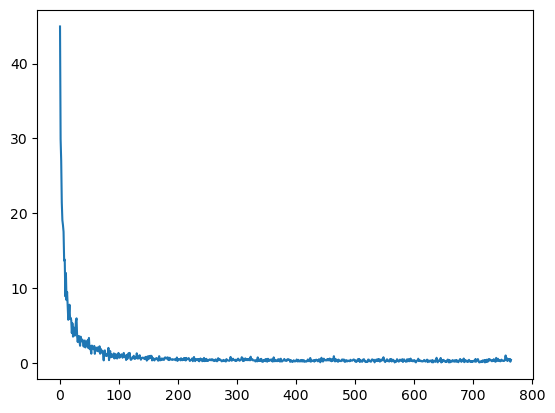

In [27]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(loss_arr)), loss_arr)

In [40]:

def confusion_matrix(y_pred: np.ndarray, y_real: np.ndarray, num_classes:int, return_macro:bool = True):

    conf_matr = np.zeros((num_classes, num_classes), dtype=np.int64)
    # y_pred = np.argmax(y_pred_softmax, axis=1)==y_real
    np.add.at(conf_matr, (y_real, y_pred), 1)

    if return_macro:
        
        macro_tp = np.diag(conf_matr)
        macro_matr = conf_matr - np.diagflat(macro_tp)
        macro_fn = np.sum(macro_matr, axis=1)
        macro_fp = np.sum(macro_matr, axis=0)

        div = (macro_tp + macro_fp)
        macro_precision = macro_tp / np.where(div>0, div, 1)
        div = (macro_tp + macro_fn)
        macro_recall = macro_tp / np.where(div>0, div, 1)


        y_pred_onehot = one_hot(y_pred, num_classes)
        y_real_onehot = one_hot(y_real, num_classes)

        micro_tp =  np.sum(y_real_onehot * y_pred_onehot)
        micro_fp = np.sum((1 - y_real_onehot) * y_pred_onehot)
        micro_fn = np.sum(y_real_onehot * (1 - y_pred_onehot))

        micro_precision = micro_tp / max(micro_tp + micro_fp, 1)
        micro_recall = micro_tp / max(micro_tp + micro_fn, 1)

        devided = micro_precision + micro_recall

        if not devided:
            devided = 1

        micro_f1 = 2 * micro_precision * micro_recall / devided
        macro_f1 = 2 * macro_precision * macro_recall / (macro_precision + macro_recall)


        return conf_matr, micro_f1, np.mean(macro_f1), np.mean(macro_precision), np.mean(macro_recall)

    return conf_matr


In [29]:
X_test1 = X_test.reshape(X_test.shape[0], 1, 28, 28)
pred_proba = model(X_test1)

In [22]:
y_test

array([4, 1, 9, ..., 4, 5, 6])

In [41]:
confusion_matrix(np.argmax(pred_proba, axis=1), y_real=y_test, num_classes=10, return_macro=True)

(array([[2061,    1,    1,    0,    1,    5,    0,    2,    3,    4],
        [   5, 2259,    7,    1,   16,    1,    4,    3,   10,    1],
        [  80,   15, 1812,   24,   31,   40,    7,   88,   16,   10],
        [  38,    4,   22, 1802,    3,  177,    0,   40,   13,   56],
        [   9,    1,    0,    0, 1984,    0,    2,    5,    2,   47],
        [  52,    1,    3,   13,    3, 1782,    6,   16,    4,   27],
        [  97,    5,    7,    0,   48,   57, 1797,    0,   10,    0],
        [  24,   14,   14,    8,    4,    4,    0, 2074,    5,   70],
        [  75,    6,   13,   16,   22,  145,    5,   26, 1601,  165],
        [  25,    4,    0,    4,   62,   19,    0,   19,    7, 1927]],
       dtype=int64),
 0.9095195009286157,
 0.9083375037888588,
 0.914706973546991,
 0.9091843266526156)